In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

# Segmentation and boundary-box regression

In [2]:
from src.utils.preprocess import tensor2numpy, image2axial,mask_threshold, preprocess_image, normalize
from src.utils import preprocess
from src.utils import plot
from src.utils.utils import split_custom_filename
from src.classifier.agent import Agent
from src.cam import CAM_TYPES, CAM
from src import segmentation
import nibabel as nib
import itertools

import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt

In [3]:
from scipy import ndimage

# Load test image and plot Mask 

In [4]:
# Variables
FILE_NAME = '../data/SPM_categorised/AIH/AD/AD_ADNI_2489.nii'
CAM_NAME = CAM_TYPES.GradCAMpp.value
CHECKPOINT_PATH = "/var/metrics/codetests/logs/tb/final/base2/resnet18_brew2/20210524224031/version_2/checkpoints/epoch=40-step=2172.ckpt"
OBSERVED_CLASSES = [0,1,2]
#filename = '../data/SPM_categorised/AIH/CN/CN_ADNI_0442.nii'
#filename = '../data/SPM_categorised/AIH/MCI/MCI_ADNI_1389.nii'

***Defined dataloader:***
Data directory: data/SPM_categorised/ADNI1/
Dataset sizes - Training: 273 Validation: 31
Seed: 0
Augmentation: Enabled
KFold: Enabled - Fold: 1/10

Loading model from /var/metrics/codetests/logs/tb/final/base2/resnet18_brew2/20210524224031/version_2/checkpoints/epoch=40-step=2172.ckpt (checkpoint)..
Architecture [ResNet] was created
***Defined hyperparameters:***
"arch":                {'name': 'resnet18_brew2', 'args': {'num_channels': 1, 'num_classes': 3}}
"checkpoint_path":     None
"class_weights":       tensor([0.9953, 1.0024, 1.0024])
"hp_metrics":          ['loss/train', 'loss/val', 'Accuracy/val', 'AUROC/val', 'Precision/val', 'Recall/val', 'Specificity/val']
"loss":                {'type': 'CrossEntropyLoss', 'args': {'weight': True}}
"optimizer":           {'type': 'Adam', 'args': {'lr': 0.001, 'weight_decay': 0, 'amsgrad': False}}
"roi_hparams":         {'enable': False, 'output_shape': [3, 3, 3], 'boundary_boxes': []}
"weight_distribution": None


/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


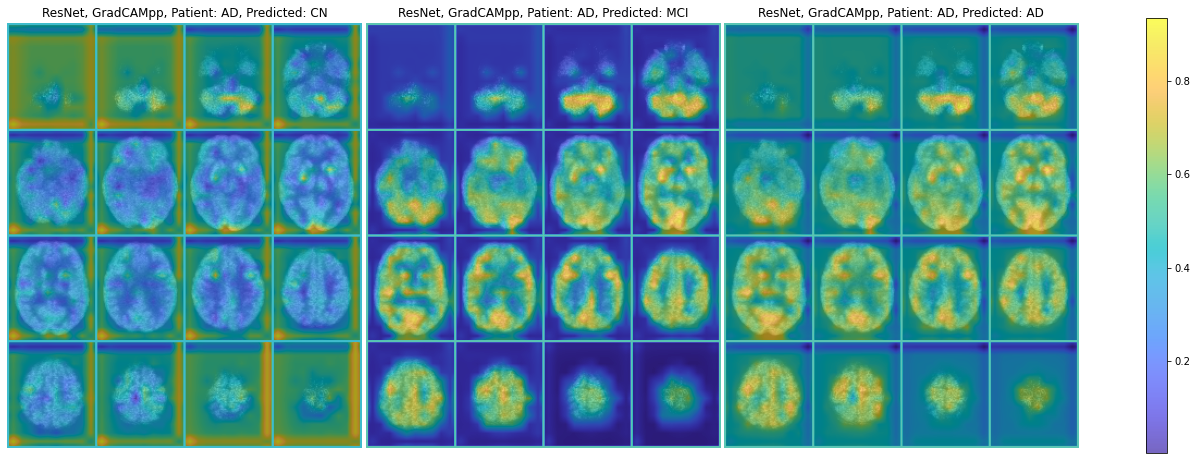

In [12]:
# Load models #resnet18_brew2/20210502200453/version_0/checkpoints/epoch=81-step=5083.ckpt

trainer = Agent(checkpoint_path=CHECKPOINT_PATH)

trainer.load_model()
model = trainer.model
dataset = trainer.dataloader
#cam_extractor = CAM(CAM_TYPES.SmoothGradCAMpp.value, model, CAM_kwargs={"std":0.01})
cam_extractor = CAM(CAM_NAME, model)
# Load example image 

class_label = split_custom_filename(FILE_NAME,'/')[4]
test_image = image2axial(nib.load(FILE_NAME).get_fdata())
test_image[test_image <= 0]=0
test_image = preprocess_image(test_image)

class_scores, class_idx = cam_extractor.evaluate(test_image)
grid_image, grid_mask = cam_extractor.grid_class(class_scores, OBSERVED_CLASSES, test_image,pad_value=0.5, max_num_slices=16, nrow=4)
masked_image = preprocess_image(cam_extractor.activation_map(class_idx, class_scores))
cam_extractor.plot(class_scores, OBSERVED_CLASSES,test_image, max_num_slices=16, class_label=class_label,nrow=4);

# Calculate average CAM

In [213]:
from src.utils.plot import imshow
from src.utils.preprocess import to_grid
from src.utils.cmap import parula_map
from src.utils.decorator import HiddenPrints
import sys,os
import warnings

In [220]:
# Variables
MODEL_CHECKPOINTS = [
        "/var/metrics/codetests/logs/tb/final/resnet18_brew2/20210524192415/version_0/checkpoints/epoch=52-step=2808.ckpt",
        #"/var/metrics/codetests/logs/tb/final/resnet18_brew2/20210524215650/version_0/checkpoints/epoch=57-step=3073.ckpt",
        #"/var/metrics/codetests/logs/tb/final/resnet18_brew2/20210524215650/version_1/checkpoints/epoch=23-step=1271.ckpt",
        #"/var/metrics/codetests/logs/tb/final/resnet18_brew2/20210524215650/version_2/checkpoints/epoch=69-step=3709.ckpt",
        #"/var/metrics/codetests/logs/tb/final/resnet18_brew2/20210524215650/version_3/checkpoints/epoch=59-step=3179.ckpt",
        #"/var/metrics/codetests/logs/tb/final/resnet18_brew2/20210524215650/version_4/checkpoints/epoch=77-step=4133.ckpt",
        #"/var/metrics/codetests/logs/tb/final/resnet18_brew2/20210524215650/version_5/checkpoints/epoch=70-step=3762.ckpt",
        #"/var/metrics/codetests/logs/tb/final/resnet18_brew2/20210524215650/version_6/checkpoints/epoch=44-step=2384.ckpt",
        #"/var/metrics/codetests/logs/tb/resnet18_brew2/20210506180525/version_0/checkpoints/epoch=98-step=6236.ckpt", 
        #"/var/metrics/codetests/logs/tb/resnet50/20210506203543/version_2/checkpoints/epoch=72-step=4598.ckpt",
        #"/var/metrics/codetests/logs/tb/vgg16/20210506221224/version_0/checkpoints/epoch=46-step=2960.ckpt",
        #"/var/metrics/codetests/logs/tb/vgg11_brew/20210507015717/version_3/checkpoints/epoch=112-step=7118.ckpt"
    ]
FILE_NAMES = ['../data/SPM_categorised/AIH/AD/AD_ADNI_2489.nii', '../data/SPM_categorised/AIH/MCI/MCI_ADNI_1389.nii', '../data/SPM_categorised/AIH/CN/CN_ADNI_0442.nii']


In [221]:
def calculate_average_cam(checkpoint_path, image, classes=[0,1,2],n=10):
    
    masks = []
   
    for i in range(n):
        
        trainer = Agent(checkpoint_path=checkpoint_path)
        trainer.load_model()
        model = trainer.model
        cam_extractor = CAM(CAM_TYPES.GradCAMpp.value, model)
        class_scores, class_idx = cam_extractor.evaluate(image)
        grid_image, grid_mask = cam_extractor.grid_class(class_scores, classes, image,pad_value=0.5, max_num_slices=16, nrow=4)

        masks.append(grid_mask)
        del trainer,grid_mask, grid_image, model, cam_extractor, class_idx, class_scores

    return masks


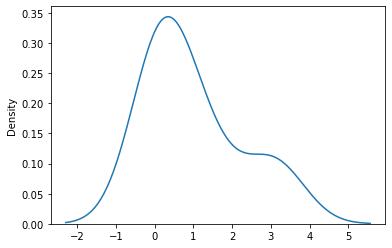

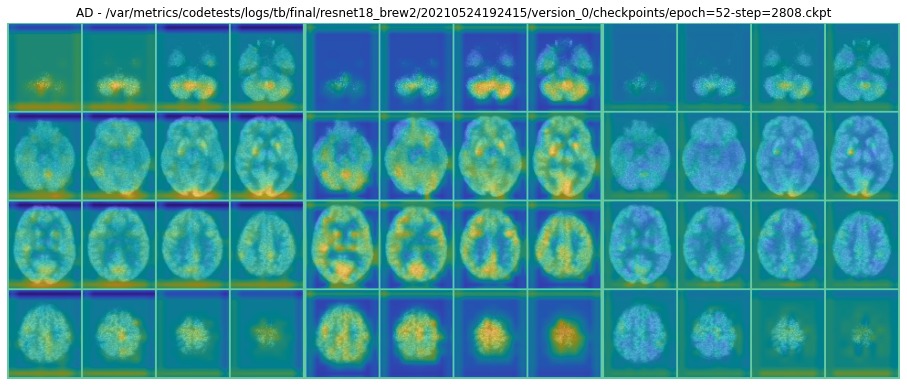

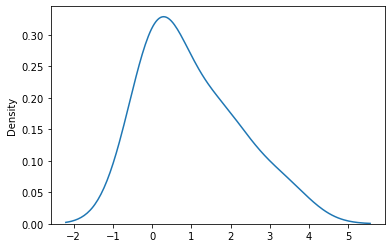

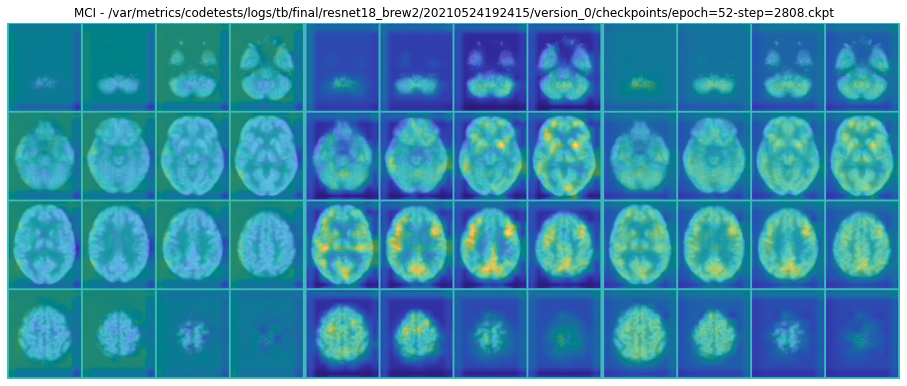

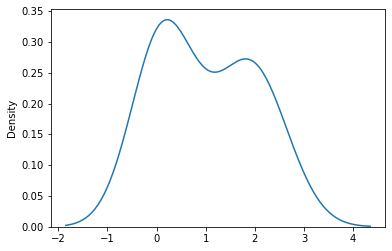

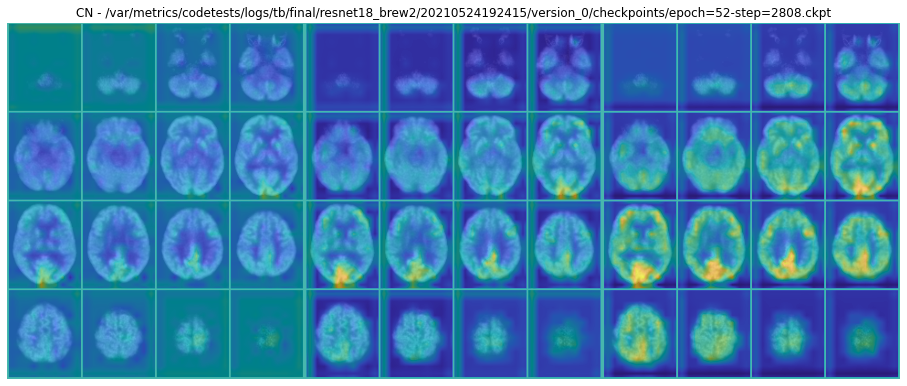

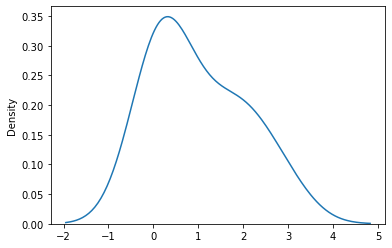

In [253]:

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with HiddenPrints():
        for checkpoint in MODEL_CHECKPOINTS:
            hist_list = []
            for filename in FILE_NAMES:
                class_label = split_custom_filename(filename,'/')[4]
                test_image = image2axial(nib.load(filename).get_fdata())
                test_image[test_image <= 0]=0
                test_image = preprocess_image(test_image)
         
                maskes= calculate_average_cam(checkpoint, test_image)
                normed_maskes = normalize(torch.mean(torch.stack(maskes), axis=0))
                
                fig = plt.figure(figsize=(16,16))
                plt.imshow(normalize(np.hstack([to_grid(test_image, max_num_slices=16,nrow=4)]*3)),cmap='Greys_r')
                im = plt.imshow(normed_maskes,cmap=parula_map, alpha=0.7) 
                plt.axis('off');
                plt.title(f"{class_label} - {checkpoint}")
                plt.show()
                del test_image, maskes
            
            sns.kdeplot(np.mean(hist_list, axis=0))


## Evaluate distribution of CAM

In [ ]:
CHECKPOINT = "/var/metrics/codetests/logs/tb/final/resnet18_brew2/20210524192415/version_0/checkpoints/epoch=52-step=2808.ckpt"
N = 2

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with HiddenPrints():

        with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
            results = list(executor.map(lambda image: calculate_average_cam(CHECKPOINT, image[1].squeeze(0), n=N), IMAGE_FILES))

plt.figure()
sns.kdeplot(np.hstack(np.hstack([tensor2numpy(torch.hstack(image)) for image in results])))
plt.xlabel("Intensity")
plt.ylabel("Density")
plt.title("Density vs intensity plot on CAM")

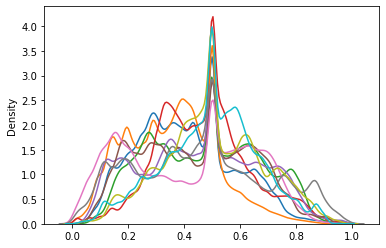

In [596]:
# Show density of each image
[sns.kdeplot(np.hstack(tensor2numpy(torch.hstack(image)))) for image in results];

## Visualise CAMs

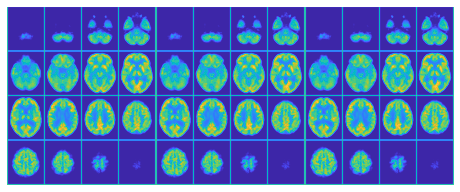

In [11]:
from src.utils.plot import imshow
imshow(grid_image)

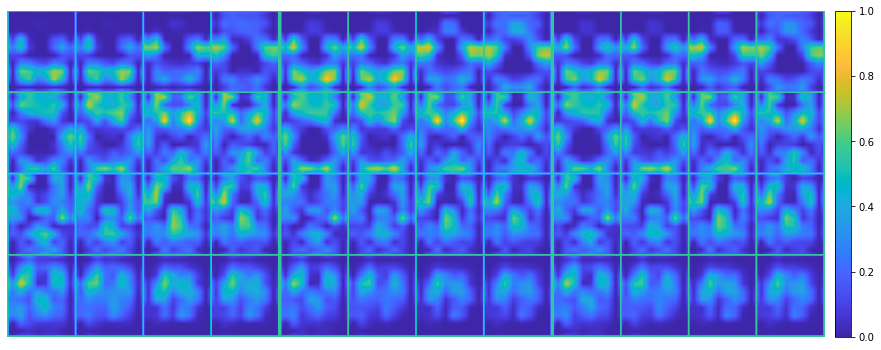

In [12]:
from src.utils.plot import imshow
imshow(preprocess_image(grid_mask, input_shape=grid_image.shape), colormap=True,colormap_shrink=1, figsize=(18,6))

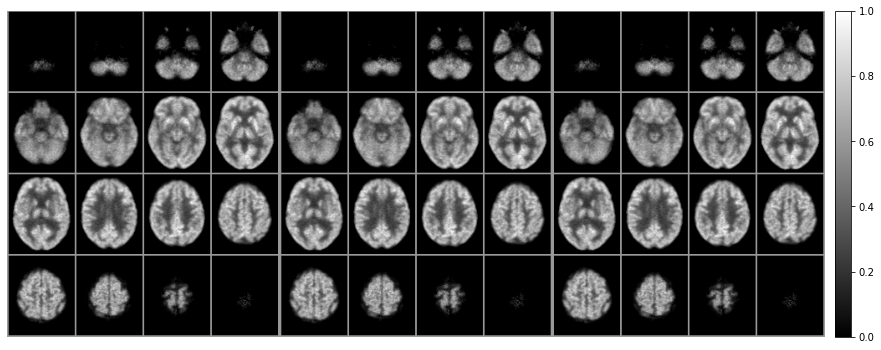

In [13]:

imshow(preprocess_image(grid_image, input_shape=grid_image.shape),cmap='gray', colormap=True,colormap_shrink=1, figsize=(18,6))

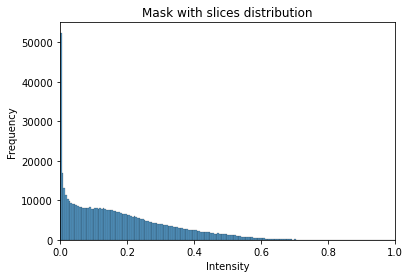

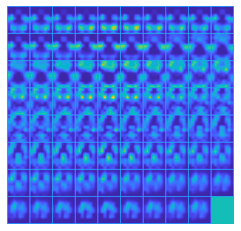

In [14]:
# Only check the distribution from each image! This looks a lot better!
sliced_masks = preprocess_image(cam_extractor.activation_map(2, class_scores))

# Remove background since this give faulty ideas otherwise
#sliced_masks[test_image == 0] = 0
#segmentation.intensity_distribution(sliced_masks[30].flatten(),title="Mask with slices distribution")
plot.intensity_distribution(sliced_masks.ravel(),title="Mask with slices distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

plot.imshow(preprocess.to_grid(sliced_masks))

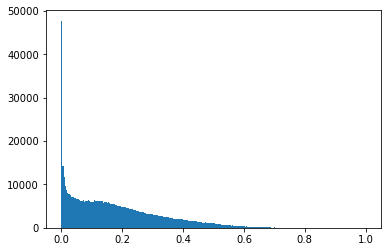

In [15]:
h, bins, patches = plt.hist(sliced_masks.ravel(), bins=255)

Tin = (h*sliced_masks.sum()).sum()/h.sum()

In [16]:
(h*sliced_masks.sum()).sum()/h.sum()

103940.234375

In [17]:
np.unique(sliced_masks.ravel())

array([0.0000000e+00, 1.7672288e-07, 2.2721512e-07, ..., 9.7744799e-01,
       9.7979206e-01, 1.0000000e+00], dtype=float32)

# Extract Segmentation and boundary boxes

In [ ]:
from src.utils.preprocess import to_grid

In [61]:
THRESHOLD = 0.95

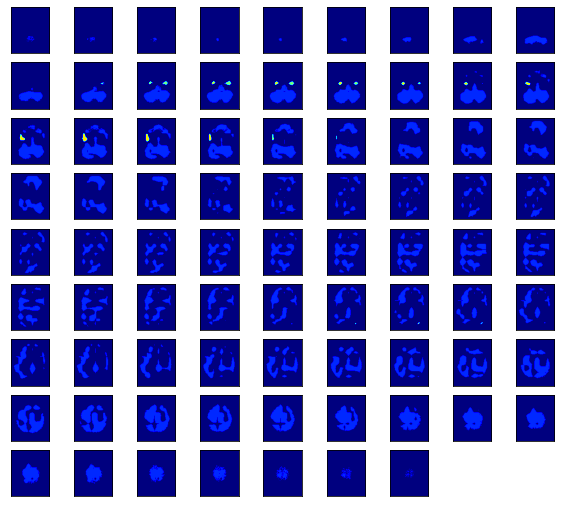

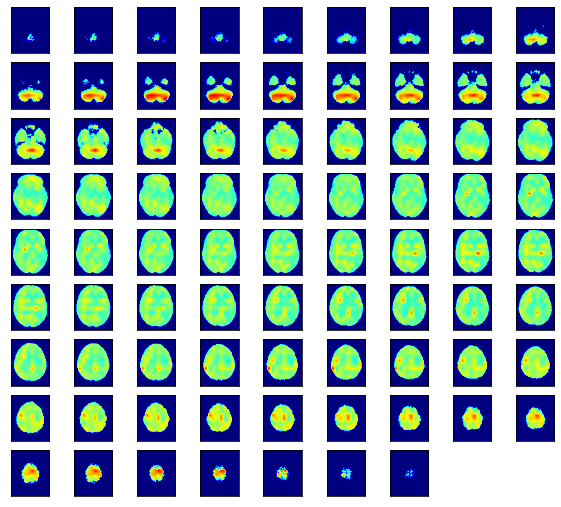

In [126]:
#features = segmentation.sequential_processing(test_image.copy(), sliced_masks.copy())
inner = segmentation.Feature_extraction(cam_extractor, upper_bound=THRESHOLD)
tmp_segmented = inner.extract(torch.from_numpy(test_image),1)
plot.display_3D(tmp_segmented[0],step=1);
plot.display_3D(tmp_segmented[1],step=1);


In [ ]:
imshow(to_grid(tmp_segmented[0],max_num_slices=16, nrow=4), colormap=True, figsize=(10,10))

In [128]:
inner = segmentation.Feature_extraction(cam_extractor, upper_bound=0.8)
features = inner.features(1,"Something", torch.from_numpy(test_image), 0,1)
features

{'image': 'Something',
 'patient_class': 0,
 'observe_class': 1,
 'probability_class': 0,
 'bbox_area': [437976, 8, 1, 1, 1, 16, 8],
 'mean_intensity': [151.3111324100254,
  145.0,
  135.0,
  137.0,
  135.0,
  135.92307692307693,
  135.75],
 'bbox': [(5, 7, 71, 91, 0, 79),
  (27, 66, 29, 68, 1, 3),
  (49, 45, 50, 46, 12, 13),
  (29, 47, 30, 48, 13, 14),
  (27, 27, 28, 28, 35, 36),
  (6, 58, 14, 60, 35, 36),
  (66, 66, 68, 68, 43, 45)],
 'upper_bound': 135.0,
 'use_quantile_bounds': True,
 'score': array([-0.19266655,  0.54602748,  0.54603929,  0.54603929,  0.54603929,
         0.54601399,  0.54602748])}

## Calculate number of unique segments 
Calculate how many unique segments are created based on different thresholds

In [186]:
NUM_WORKERS = 8
THRESHOLD_BOUNDARY = [0.5,1.0]
THRESHOLD_STEP = 0.05
IMAGE_FILES = [[idx, tmp_image, something, target_class] for (idx, (tmp_image, something)), target_class in itertools.product(enumerate(FILESET),OBSERVE_CLASSES)]

In [ ]:
def average_threshold_segments(extractor, idx, tmp_image, patient_class, target_class):
    return len(extractor.features(1,"Something", tmp_image, patient_class,target_class)['bbox_area'])

data = {"Threshold":[], "Frequency":[]}

for threshold in [*np.arange(*THRESHOLD_BOUNDARY, THRESHOLD_STEP), THRESHOLD_BOUNDARY[1]]:
    extractor = segmentation.Feature_extraction(cam_extractor, upper_bound=threshold)
    print(f"Threshold: {threshold}", end="\r")
    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        results = list(executor.map(lambda x: average_threshold_segments(extractor, *x), IMAGE_FILES))
        data["Threshold"].append(round(threshold,3))
        data["Frequency"].append(round(sum(results)/len(results),2))
        #print(f"Threshold: {round(threshold,3)} - {round(sum(results)/len(results),2)}")
        
derp = pd.DataFrame.from_dict(data)#(list(data.items()))#.transpose()
plt.figure(figsize=(18,8))
plt.title("Analysis of threshold and number of segments")
ax = sns.barplot(x="Threshold",y="Frequency",data=derp, palette='rocket')

/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# RoIAlign

In [ ]:
tmp_roialign = segmentation.roi_align(test_image, features['bbox'], displayed=True)
#imshow(to_grid(tensor2numpy(tmp_roialign[0][0]),max_num_slices=16, nrow=5), colormap=True)

In [ ]:
imshow(to_grid(tensor2numpy(tmp_roialign[0][0]),max_num_slices=25, nrow=5), colormap=True, figsize=(18,6))

In [ ]:
imshow(to_grid(np.stack([to_grid(tensor2numpy(x[0]),max_num_slices=25, nrow=5,pad_value=0.1) for x in tmp_roialign]), pad_value=0.5), colormap=True, figsize=(30,5))

# Extract regions

In [6]:
import pandas as pd
from multiprocessing import Pool
from datetime import datetime
from src.utils.preprocess import to_grid
from concurrent.futures import ThreadPoolExecutor
from src.utils.utils import create_directory
import os

In [38]:
# Parameters
CALCULATE_BBOX = True
BBOX_FILENAME = r'../logs/bbox/resnet50/bbox_2021-04-22 17:08:06.333885.csv'
THRESHOLD = 0.9
OBSERVE_CLASSES = [0,1,2]
FILESET = dataset.val_dataloader().dataset
FILESET_PRODUCT = list(itertools.product(enumerate(FILESET),OBSERVE_CLASSES))

In [30]:

tmp_slices = sliced_masks.copy()
tmp_slices[test_image == 0] = 0
plot.display_3D(tmp_slices);

NameError: name 'sliced_masks' is not defined

In [40]:
if CALCULATE_BBOX:
    
    extraction_method = segmentation.Feature_extraction(cam_extractor, upper_bound=THRESHOLD)
        
    with ThreadPoolExecutor(max_workers=10) as executor:
        #results = executor.map(lambda p: extraction_method.features(*p) ,((i, FILESET.data[i].rsplit("/",1)[1],image, patient_class, observe_class) for (i, (image, patient_class)), observe_class in FILESET_PRODUCT))
        results = executor.map(lambda p: extraction_method.features(*p) ,((i, FILESET.data[i].rsplit("/",1)[1],image, patient_class, observe_class) for (i, (image, patient_class)), observe_class in FILESET_PRODUCT))

    bboxes_dict = list(results)
    # Convert data to dataframe
    bboxes_df = pd.DataFrame(bboxes_dict)
    bboxes_df.rename(columns = {'index' : 'image', 'bbox':'bbox'}, inplace = True)
    bboxes_df['bbox_count'] = bboxes_df['bbox'].str.len()
    bboxes_df = bboxes_df[bboxes_df['bbox_count']>0]
    bboxes_df = bboxes_df.apply(pd.Series.explode)
    bboxes_df['bbox'] = bboxes_df['bbox'].apply(lambda row: list(row))
    
    bboxes_df.reset_index(inplace = True)
    bboxes_df.rename(columns = {'index' : 'Image_class'}, inplace = True)
    bboxes_df.head(20)

    # Sort data
    bboxes_df.sort_values('score',ascending=False,inplace=True)
    
    # Save to logs
    
    now = datetime.now()
    name = f"../logs/bbox/{model._hparams['arch']['name']}/bbox_{now}.csv"
    os.makedirs(f"../logs/bbox/{model._hparams['arch']['name']}", exist_ok=True)
    bboxes_df.to_csv(name,index=False,header=True)

else:
    bboxes_df = pd.read_csv(BBOX_FILENAME, dtype={'patient_class':int, 'observe_class':int,'probability_class':int,'bbox_count':int})
    bboxes_df['bbox'] = segmentation.column_to_np(segmentation.column_to_tuple(bboxes_df['bbox']))

In [32]:
bboxes_df.head(40)

Image_class                                              image  \
131           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
132           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
135           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
138           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
134           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
133           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
139           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
140           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
137           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
136           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
130           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
129           21  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
258           33  iwADNI_130_S_0289_PT_PET_ADNI__Brain__br_raw_2...   
262           33  iwADNI_130_S_0289_PT_PET_ADNI__Brain__br_raw_2...   
257           33  iwADNI_130_S_0289_PT_PET_ADNI__Brain__br_raw_2...   
256           33  iwADNI_130_S_0289_PT_PET_ADNI__Brain__br_raw_2...   
259           33  iwADNI_130_S_0289_PT_PET_ADNI__Brain__br_raw_2...   
260           33  iwADNI_130_S_0289_PT_PET_ADNI__Brain__br_raw_2...   
255           33  iwADNI_130_S_0289_PT_PET_ADNI__Brain__br_raw_2...   
261           33  iwADNI_130_S_0289_PT_PET_ADNI__Brain__br_raw_2...   
214           28  iwADNI_024_S_1393_PET_Dynamic_2_FDG_4i_16s__br...   
211           28  iwADNI_024_S_1393_PET_Dynamic_2_FDG_4i_16s__br...   
210           28  iwADNI_024_S_1393_PET_Dynamic_2_FDG_4i_16s__br...   
213           28  iwADNI_024_S_1393_PET_Dynamic_2_FDG_4i_16s__br...   
209           28  iwADNI_024_S_1393_PET_Dynamic_2_FDG_4i_16s__br...   
212           28  iwADNI_024_S_1393_PET_Dynamic_2_FDG_4i_16s__br...   
522           61  iwADNI_005_S_0222_PET_30_min_3D_FDG_-_Iter_Bra...   
524           62  iwADNI_005_S_0222_PET_30_min_3D_FDG_-_Iter_Bra...   
632           75  iwADNI_029_S_0866_PET_ADNI_Brain_PET__Raw_br_r...   
631           75  iwADNI_029_S_0866_PET_ADNI_Brain_PET__Raw_br_r...   
634           75  iwADNI_029_S_0866_PET_ADNI_Brain_PET__Raw_br_r...   
633           75  iwADNI_029_S_0866_PET_ADNI_Brain_PET__Raw_br_r...   
637           75  iwADNI_029_S_0866_PET_ADNI_Brain_PET__Raw_br_r...   
636           75  iwADNI_029_S_0866_PET_ADNI_Brain_PET__Raw_br_r...   
635           75  iwADNI_029_S_0866_PET_ADNI_Brain_PET__Raw_br_r...   
186           25  iwADNI_033_S_0511_PT_ADNI_STATIC_BRAIN__br_raw...   
191           26  iwADNI_033_S_0511_PT_ADNI_STATIC_BRAIN__br_raw...   
193           26  iwADNI_033_S_0511_PT_ADNI_STATIC_BRAIN__br_raw...   
188           25  iwADNI_033_S_0511_PT_ADNI_STATIC_BRAIN__br_raw...   
185           25  iwADNI_033_S_0511_PT_ADNI_STATIC_BRAIN__br_raw...   

     patient_class  observe_class  probability_class bbox_area mean_intensity  \
131              1              0                  2         1          165.0   
132              1              0                  2         1          167.0   
135              1              0                  2         1          166.0   
138              1              0                  2         1          167.0   
134              1              0                  2         6     171.666667   
133              1              0                  2        16     169.428571   
139              1              0                  2        16         169.75   
140              1              0                  2        30     167.416667   
137              1              0                  2        64     172.583333   
136              1              0                  2        72     169.647059   
130              1              0                  2       252     169.816092   
129              1              0                  2       330     168.811688   
258              1              0       

# Check distributions for validating clusters

<AxesSubplot:>

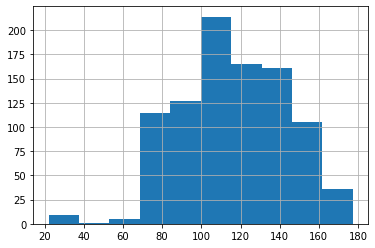

In [22]:
bboxes_df.mean_intensity.hist() # x: snitt intensitet, y: Frekvens

<AxesSubplot:>

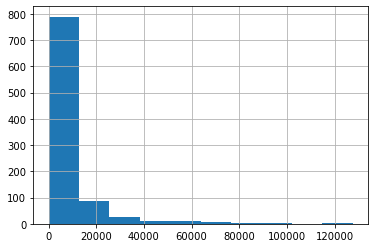

In [23]:
bboxes_df.bbox_area.hist() # x:storlek i pixlar, y: Frekvens

In [41]:
def plot_bbox_category_scatter(bboxes_df, upper_limit=None, lower_limit=None):
    _bboxes_df = bboxes_df.copy()
    if upper_limit:
        _bboxes_df = _bboxes_df.loc[_bboxes_df['bbox_area']<=upper_limit]
    if lower_limit:
        _bboxes_df = _bboxes_df.loc[_bboxes_df['bbox_area']>=lower_limit]
    
    cn_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 0) & (_bboxes_df['patient_class'] == 0) ]
    mci_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 1) & (_bboxes_df['patient_class'] == 1)]
    ad_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 2) & (_bboxes_df['patient_class'] == 2)]

    fig = plt.figure()
    plt.title("Relation between area and intensity")
    plt.xlabel("Intensity")
    plt.ylabel("Area")
    plt.scatter(cn_bboxes.mean_intensity,cn_bboxes.bbox_area,color='blue',label='CN',alpha=0.5)
    plt.scatter(mci_bboxes.mean_intensity,mci_bboxes.bbox_area,color='green',label='MCI',alpha=0.5)
    plt.scatter(ad_bboxes.mean_intensity,ad_bboxes.bbox_area,color='purple',label='AD',alpha=0.5)
    #plt.plot((100,240),(0,400000), color='red')
    plt.legend(loc='upper left')
    plt.show()
    return cn_bboxes,mci_bboxes,ad_bboxes

In [42]:
bboxes_df.loc[(bboxes_df['bbox_area'] > 20000) & (bboxes_df['bbox_area'] < 170000)]

Image_class                                              image  \
457           62  iwADNI_005_S_0222_PET_30_min_3D_FDG_-_Iter_Bra...   
440           60  iwADNI_005_S_0222_PET_30_min_3D_FDG_-_Iter_Bra...   
507           72  iwADNI_116_S_0360_PET_3D_Emission_6i_16s__br_r...   
71             8  iwADNI_033_S_1281_PT_ADNI_STATIC_BRAIN__br_raw...   
67             8  iwADNI_033_S_1281_PT_ADNI_STATIC_BRAIN__br_raw...   
347           48  iwADNI_127_S_0925_PET_30_min_3D_FDG_-_Iter_Bra...   

     patient_class  observe_class  probability_class bbox_area mean_intensity  \
457              1              2                  2     31824     177.413439   
440              1              0                  2     23001     127.193503   
507              0              0                  2     79380     136.824735   
71               2              2                  2    138600     137.675082   
67               2              2                  2    160552     144.147939   
347              1              0                  2    107160      97.722944   

                         bbox  upper_bound  use_quantile_bounds     score  \
457  [11, 32, 63, 68, 31, 48]        169.0                 True  0.626282   
440  [18, 73, 59, 90, 17, 50]        106.0                 True  0.467472   
507   [18, 55, 63, 91, 0, 49]        119.0                 True  0.368067   
71    [7, 26, 70, 70, 27, 77]        123.0                 True  0.280689   
67    [14, 45, 70, 92, 7, 68]        123.0                 True  0.243663   
347   [16, 54, 63, 92, 0, 60]         75.0                 True  0.147017   

     bbox_count  
457           6  
440          13  
507          19  
71           10  
67           10  
347          24

# Plot relation between area and intensity

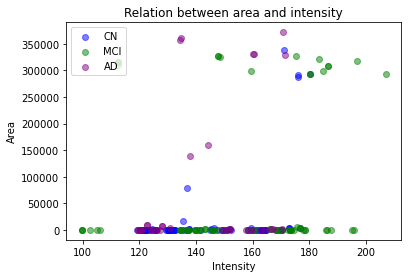

In [69]:
cn_bboxes, mci_bboxes, ad_bboxes = plot_bbox_category_scatter(bboxes_df, lower_limit=10)

## Evalaute threshold
Calculate average number of boxes based on threshold for each 

In [116]:
import seaborn as sns

In [107]:
THRESHOLD_BOUNDARY = [0.0,1.0]
THRESHOLD_STEP = 0.05
BBOXES = {'CN':cn_bboxes, 'MCI':mci_bboxes, 'AD':ad_bboxes}
IMAGE_MASK = test_image

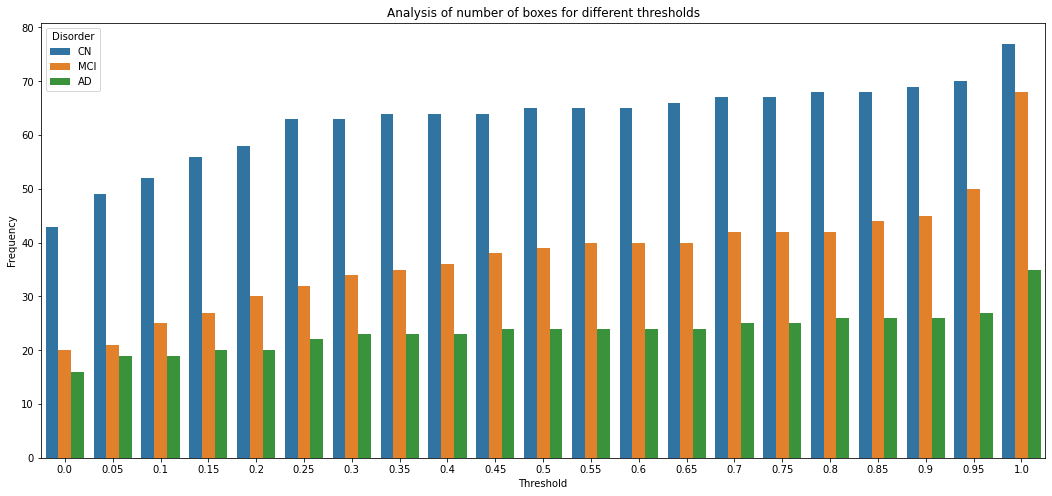

In [184]:
def average_threshold_boxes(suggested_boxes, threshold): 
    return segmentation.nms_reduction(suggested_boxes[suggested_boxes['score']>0.0],image_mask=IMAGE_MASK,th=threshold)

data = {"Threshold":[], "Disorder":[], "Frequency": []}
for threshold in [*np.arange(*THRESHOLD_BOUNDARY, THRESHOLD_STEP), THRESHOLD_BOUNDARY[1]]:
    #print(f"Threshold: {round(threshold,3)}")
    
    for bbox_name,bbox_items in BBOXES.items():
        results = average_threshold_boxes(bbox_items, threshold).shape[0]
        #print(f"\tBBOX Name: {bbox_name} - {results}")
        data["Threshold"].append(round(threshold,2))
        data["Frequency"].append(results)
        data["Disorder"].append(bbox_name)
        
derp = pd.DataFrame.from_dict(data)#(list(data.items()))#.transpose()
plt.figure(figsize=(18,8))
plt.title("Analysis of number of boxes for different thresholds")
ax = sns.barplot(x="Threshold",y="Frequency", hue='Disorder',data=derp)

# Plot suggested bounding boxes for each class

In [44]:
# show df for AD
ad_bboxes

Image_class                                              image  \
71             8  iwADNI_033_S_1281_PT_ADNI_STATIC_BRAIN__br_raw...   
67             8  iwADNI_033_S_1281_PT_ADNI_STATIC_BRAIN__br_raw...   
94            11  iwADNI_127_S_0754_PT_127_S_0754_fdg_br_raw_200...   
131           17  iwADNI_099_S_1144_PT_PET_WB_br_raw_20090216121...   
113           14  iwADNI_003_S_1257_PT_ADNI_br_raw_2007092712453...   
149           20  iwADNI_029_S_1056_PET_ADNI_Brain_PET__Raw_br_r...   
13             2  iwADNI_109_S_1157_PET_30_MIN_3D_FDG_6i_16s__br...   
40             5  iwADNI_011_S_0010_PET_30_min_3D_FDG_4i_16s__br...   

     patient_class  observe_class  probability_class bbox_area mean_intensity  \
71               2              2                  2    138600     137.675082   
67               2              2                  2    160552     144.147939   
94               2              2                  2    328860     171.267453   
131              2              2                  2    330400     160.262192   
113              2              2                  2    330931     160.173689   
149              2              2                  2    371952     170.765153   
13               2              2                  2    356562     134.370895   
40               2              2                  2    361584     134.559217   

                        bbox  upper_bound  use_quantile_bounds     score  \
71   [7, 26, 70, 70, 27, 77]        123.0                 True  0.280689   
67   [14, 45, 70, 92, 7, 68]        123.0                 True  0.243663   
94   [11, 11, 69, 92, 8, 78]        159.0                 True  0.090169   
131  [10, 12, 69, 92, 7, 77]        148.0                 True  0.035748   
113  [10, 12, 69, 91, 7, 78]        148.0                 True  0.033683   
149  [10, 10, 73, 92, 0, 72]        157.0                 True  0.008923   
13   [10, 11, 72, 92, 7, 78]        119.0                 True -0.116888   
40   [10, 11, 72, 92, 7, 79]        119.0                 True  -0.12633   

     bbox_count  
71           10  
67           10  
94            5  
131           7  
113           7  
149          12  
13            9  
40            9

In [45]:
# show df for MCI
mci_bboxes

Image_class                                              image  \
174           22  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   
449           61  iwADNI_005_S_0222_PET_30_min_3D_FDG_-_Iter_Bra...   
222           31  iwADNI_099_S_0551_PT_PET_WB_br_raw_20090624160...   
465           64  iwADNI_099_S_0054_PT_PET_WB_br_raw_20081211084...   
483           67  iwADNI_007_S_0101_PT_TRANSAXIAL_BRAIN_3D_FDG_A...   
190           25  iwADNI_033_S_0511_PT_ADNI_STATIC_BRAIN__br_raw...   
206           28  iwADNI_024_S_1393_PET_Dynamic_2_FDG_4i_16s__br...   
334           46  iwADNI_036_S_0673_PET_30_MIN_3D_FDG_4i_16s__br...   
427           58  iwADNI_037_S_1078_PET_ADNI__3D_FDG_4i_16s__PIB...   
237           34  iwADNI_130_S_0289_PT_PET_ADNI__Brain__br_raw_2...   
308           43  iwADNI_127_S_0394_PET_30_min_3D_FDG_4i_16s__br...   
262           37  iwADNI_036_S_0656_PET_30_MIN_3D_FDG_4i_16s__br...   
284           40  iwADNI_021_S_0231_PT_ADNI_STATIC_6X5__br_raw_2...   
371           49  iwADNI_127_S_0925_PET_30_min_3D_FDG_-_Iter_Bra...   
386           52  iwADNI_094_S_1417_PET_30MIN_3D_FDG_4i_16s__br_...   
401           55  iwADNI_033_S_0906_PT_ADNI_STATIC_BRAIN__br_raw...   

     patient_class  observe_class  probability_class bbox_area mean_intensity  \
174              1              1                  2    293880     207.018934   
449              1              1                  2    318054     196.773404   
222              1              1                  2    299130     184.652911   
465              1              1                  2    292640     180.237715   
483              1              1                  2    292640     180.164664   
190              1              1                  2    308416     186.570018   
206              1              1                  2    308416     186.567171   
334              1              1                  2    322080     183.293126   
427              1              1                  2    298778     159.467558   
237              1              1                  2    327600     175.107337   
308              1              1                  2    325376      148.53208   
262              1              1                  2    326592     147.724901   
284              1              1                  2    327680     147.640646   
371              1              1                  2    310310     112.510083   
386              1              1                  2    315084     112.406597   
401              1              1                  2    315084     112.432917   

                         bbox  upper_bound  use_quantile_bounds     score  \
174  [11, 11, 71, 90, 10, 72]        194.0                 True   0.28058   
449  [10, 11, 71, 90, 10, 76]        184.0                 True  0.205073   
222   [11, 11, 70, 89, 9, 74]        172.0                 True  0.199884   
465  [10, 11, 69, 91, 10, 72]        168.0                 True  0.184256   
483  [10, 11, 69, 91, 10, 72]        168.0                 True  0.184208   
190   [11, 11, 72, 90, 9, 73]        172.0                 True  0.173403   
206   [11, 11, 72, 90, 9, 73]        172.0                 True  0.169302   
334   [11, 11, 72, 91, 8, 74]        166.0                 True  0.143917   
427   [11, 11, 72, 90, 8, 70]        145.0                 True  0.108552   
237   [11, 10, 74, 90, 8, 73]        158.0                 True  0.088039   
308   [10, 10, 74, 92, 7, 69]        136.0                 True  0.001768   
262   [10, 11, 73, 92, 7, 71]        134.0                 True -0.004006   
284   [10, 11, 74, 91, 7, 71]        134.0                 True -0.007584   
371    [9, 15, 71, 92, 6, 71]         99.0                 True -0.088752   
386    [9, 15, 71, 92, 5, 71]         99.0                 True -0.101434   
401    [9, 15, 71, 92, 5, 71]         99.0                 True -0.104537   

     bbox_count  
174           4  
449           4  
222           2  
465           6  
483           6  
1

In [46]:
# show df for CN
cn_bboxes

Image_class                                              image  \
644           90  iwADNI_062_S_1099_PT_PET_BRAIN__br_raw_2007060...   
507           72  iwADNI_116_S_0360_PET_3D_Emission_6i_16s__br_r...   
495           69  iwADNI_020_S_0883_PT_PET_Brain_COR_ADNI_br_raw...   
598           84  iwADNI_037_S_0327_PT_ADNI_FDG_Brain_br_raw_200...   
577           81  iwADNI_009_S_0842_PT_3D_BRAIN_ADNI__br_raw_200...   
556           78  iwADNI_941_S_1195_PT_ADNI_Brain_PET__Raw_br_ra...   

     patient_class  observe_class  probability_class bbox_area mean_intensity  \
644              0              0                  2     16560     135.481149   
507              0              0                  2     79380     136.824735   
495              0              0                  2    292640     180.169795   
598              0              0                  2    287680     175.925617   
577              0              0                  2    291276     175.982362   
556              0              0                  2    337680     170.948633   

                         bbox  upper_bound  use_quantile_bounds     score  \
644   [16, 54, 62, 78, 0, 15]        128.0                 True  0.528495   
507   [18, 55, 63, 91, 0, 49]        119.0                 True  0.368067   
495  [10, 11, 69, 91, 10, 72]        168.0                 True  0.184212   
598   [10, 11, 68, 91, 9, 71]        161.0                 True  0.171839   
577   [10, 11, 68, 92, 9, 71]        161.0                 True  0.165643   
556    [9, 11, 72, 91, 9, 76]        157.0                 True  0.071164   

     bbox_count  
644          22  
507          19  
495           6  
598           7  
577           7  
556           7

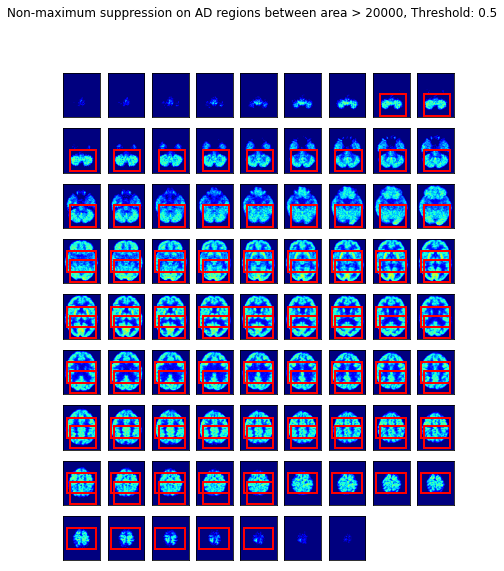

In [68]:
# Plot bbox for AD
ad_interesting, fig = segmentation.nms_reduction(ad_bboxes[ad_bboxes['score']>0.0],image_mask=test_image,th=0.3)
fig.suptitle("Non-maximum suppression on AD regions between area > 20000, Threshold: 0.5")

plt.show()

In [48]:
ad_interesting

tensor([[ 7., 26., 70., 70., 27., 77.]])

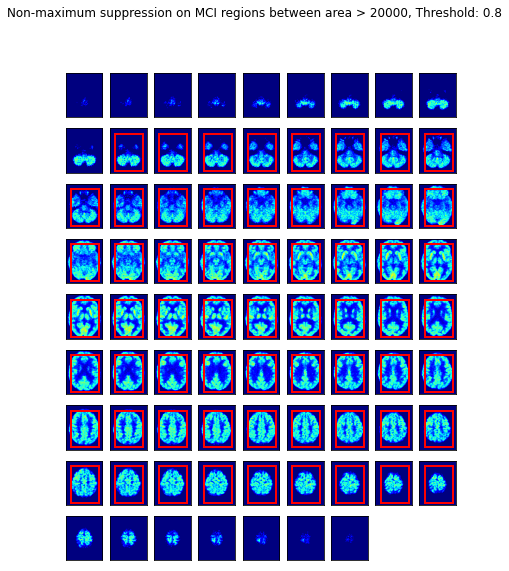

In [59]:
# Plot bbox for MCI
mci_interesting, fig = segmentation.nms_reduction(mci_bboxes[mci_bboxes['score']>0.0],image_mask=test_image, th=0.8)
fig.suptitle("Non-maximum suppression on MCI regions between area > 20000, Threshold: 0.8")
plt.show()

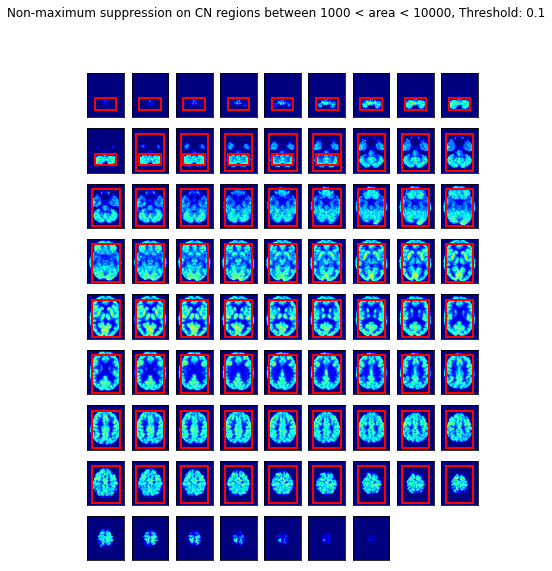

In [50]:
# Plot bbox for CN
#cn_interesting,fig = segmentation.plot_interesting_bbox(cn_bboxes[(cn_bboxes['bbox_area'] <10000) & (cn_bboxes['bbox_area'] >1000)], th=0.1)
cn_interesting,fig = segmentation.nms_reduction(cn_bboxes[cn_bboxes['score']>0], image_mask=test_image,th=0.1)

fig.suptitle("Non-maximum suppression on CN regions between 1000 < area < 10000, Threshold: 0.1")
plt.show()

In [51]:
cn_interesting

tensor([[16., 54., 62., 78.,  0., 15.],
        [10., 11., 69., 91., 10., 72.]])

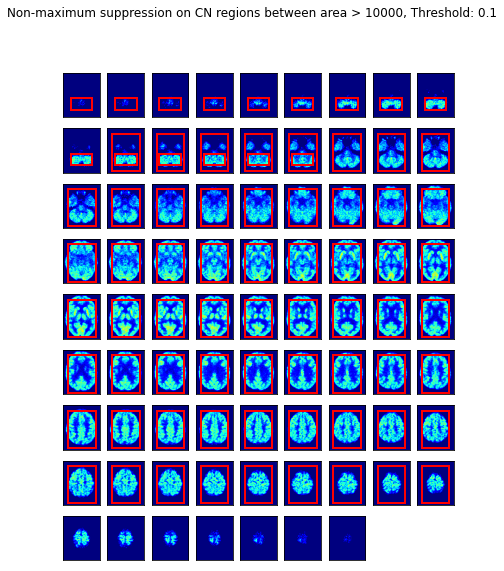

In [52]:
# Plot bbox for CN with another condition
cn_interesting2,fig = segmentation.nms_reduction(cn_bboxes[cn_bboxes['score']>0.0], image_mask=test_image,th=0.1)
fig.suptitle("Non-maximum suppression on CN regions between area > 10000, Threshold: 0.1")
plt.show()

In [53]:
def find_interesting_from_df(df_data, interesting_data):
    new_rows = df_data.apply(lambda row: row if list(row.bbox) in interesting_data.int().tolist() else 0, axis=1)
    return new_rows[new_rows['bbox'] != 0]

# Number of total boxes
print(ad_bboxes.shape[0])
print(mci_bboxes.shape[0])
print(cn_bboxes.shape[0])

8
16
6


In [54]:
find_interesting_from_df(ad_bboxes, ad_interesting)

Image_class                                              image  \
71            8  iwADNI_033_S_1281_PT_ADNI_STATIC_BRAIN__br_raw...   

    patient_class  observe_class  probability_class  bbox_area  \
71              2              2                  2     138600   

    mean_intensity                     bbox  upper_bound use_quantile_bounds  \
71      137.675082  [7, 26, 70, 70, 27, 77]        123.0                True   

       score  bbox_count  
71  0.280689          10

In [55]:
find_interesting_from_df(mci_bboxes, mci_interesting)

Image_class                                              image  \
174           22  iwADNI_033_S_0723_PT_ADNI_STATIC_BRAIN__br_raw...   

     patient_class  observe_class  probability_class  bbox_area  \
174              1              1                  2     293880   

     mean_intensity                      bbox  upper_bound  \
174      207.018934  [11, 11, 71, 90, 10, 72]        194.0   

    use_quantile_bounds    score  bbox_count  
174                True  0.28058           4

In [56]:
find_interesting_from_df(cn_bboxes, cn_interesting)

Image_class                                              image  \
644           90  iwADNI_062_S_1099_PT_PET_BRAIN__br_raw_2007060...   
495           69  iwADNI_020_S_0883_PT_PET_Brain_COR_ADNI_br_raw...   

     patient_class  observe_class  probability_class  bbox_area  \
644              0              0                  2      16560   
495              0              0                  2     292640   

     mean_intensity                      bbox  upper_bound  \
644      135.481149   [16, 54, 62, 78, 0, 15]        128.0   
495      180.169795  [10, 11, 69, 91, 10, 72]        168.0   

    use_quantile_bounds     score  bbox_count  
644                True  0.528495          22  
495                True  0.184212           6

In [57]:
print(f'AD: \n{ad_interesting.int()}\nMCI: \n{mci_interesting.int()}\nCN: \n{cn_interesting.int()}')

AD: 
tensor([[ 7, 26, 70, 70, 27, 77]], dtype=torch.int32)
MCI: 
tensor([[11, 11, 71, 90, 10, 72]], dtype=torch.int32)
CN: 
tensor([[16, 54, 62, 78,  0, 15],
        [10, 11, 69, 91, 10, 72]], dtype=torch.int32)


In [46]:
# Create list of bbox that can be loaded.
merge_interesting_boxes = np.stack([*ad_interesting,*mci_interesting,*cn_interesting,*cn_interesting2])
merge_interesting_boxes

array([[45., 18., 65., 48., 22., 41.],
       [14., 13., 32., 47., 22., 41.],
       [ 7., 28., 30., 50., 50., 74.],
       [21., 70., 55., 92., 23., 46.],
       [19., 66., 61., 84.,  0., 17.],
       [13., 62., 62., 82.,  1., 14.],
       [23., 71., 54., 92., 23., 45.],
       [14., 10., 62., 43., 22., 38.],
       [24., 42., 67., 76., 43., 67.],
       [16., 22., 57., 62., 67., 78.],
       [13., 24., 50., 46., 59., 75.],
       [12.,  4., 37., 40., 23., 39.],
       [24., 41., 49., 83., 39., 67.],
       [14., 59., 65., 82.,  0., 17.],
       [44.,  6., 65., 46., 22., 41.],
       [13., 24., 50., 46., 59., 75.],
       [12.,  4., 37., 40., 23., 39.],
       [24., 41., 49., 83., 39., 67.],
       [14., 59., 65., 82.,  0., 17.],
       [44.,  6., 65., 46., 22., 41.]], dtype=float32)

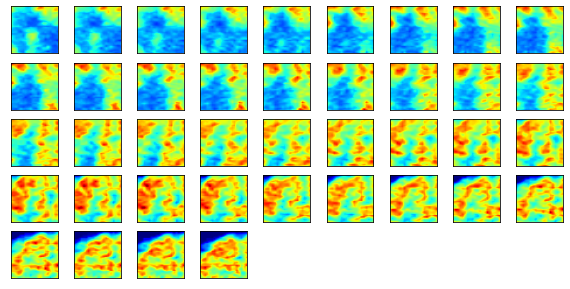

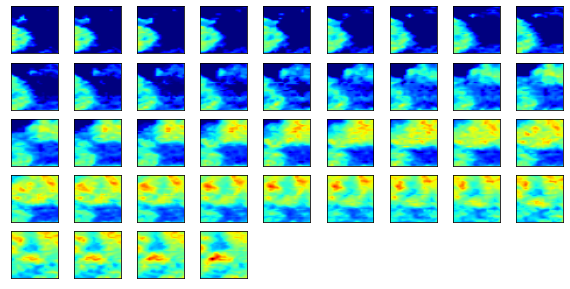

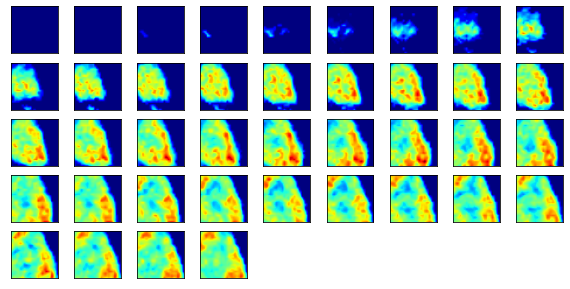

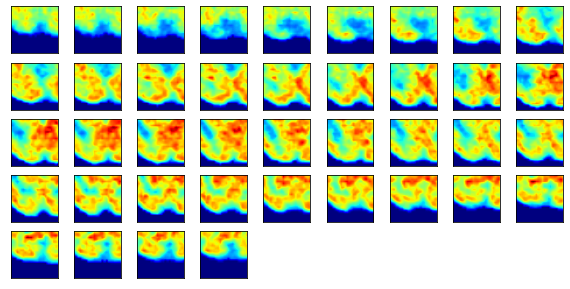

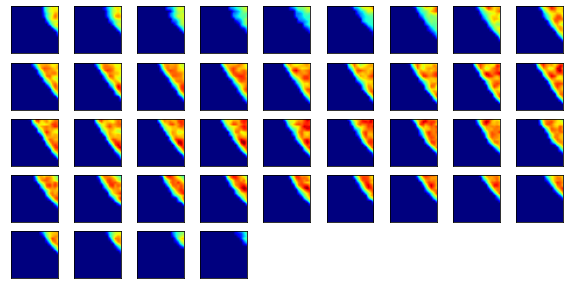

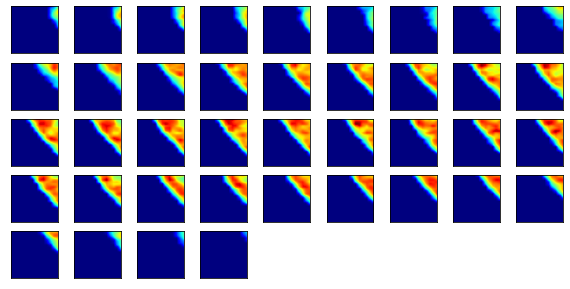

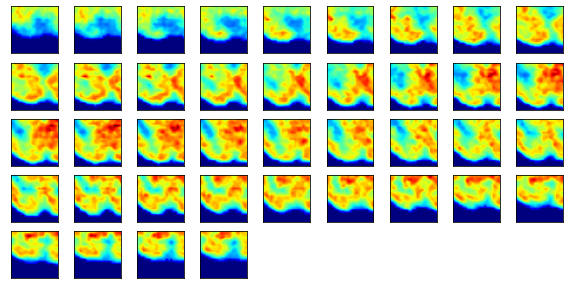

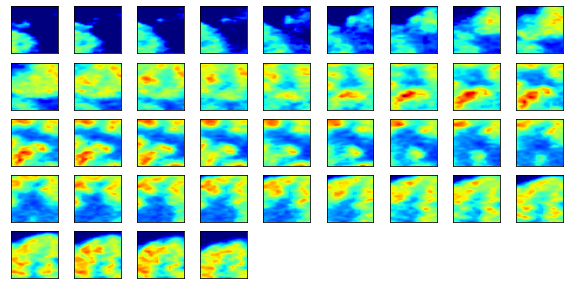

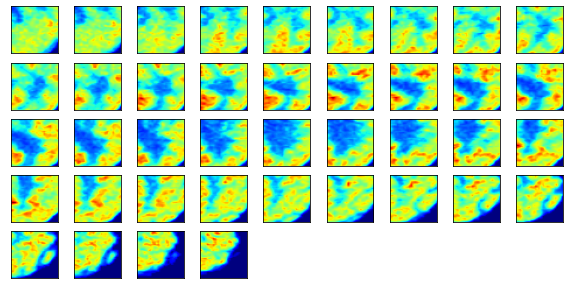

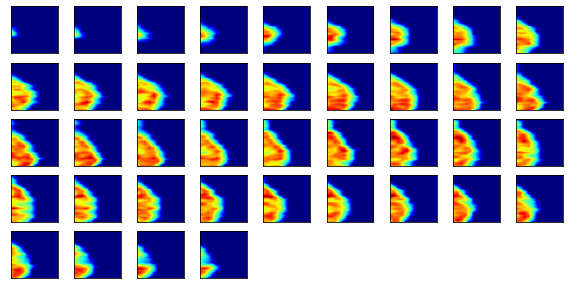

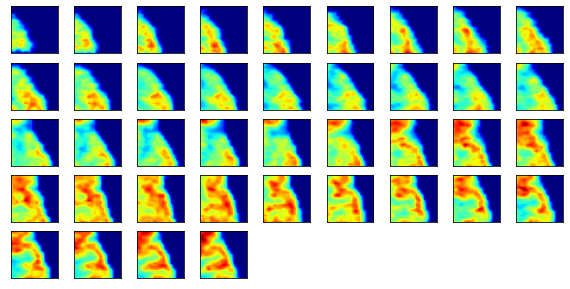

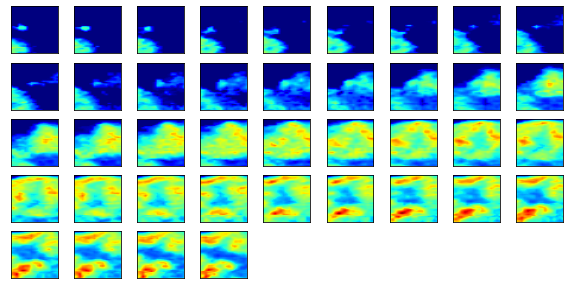

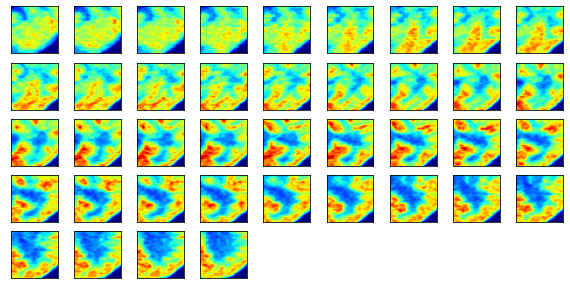

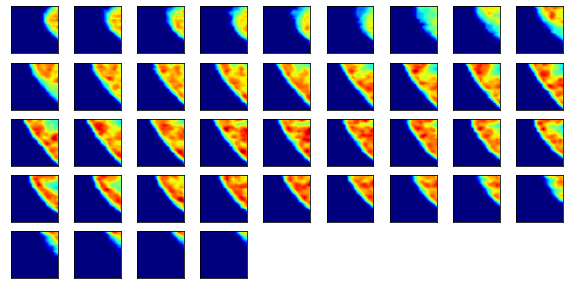

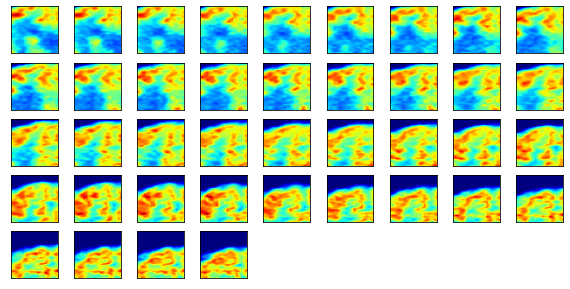

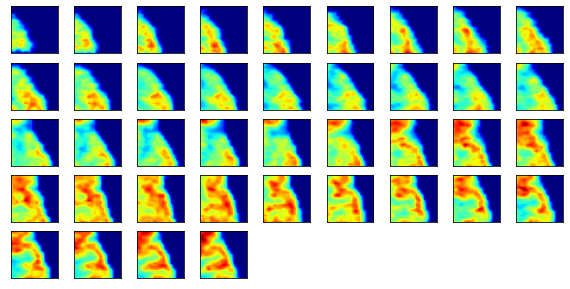

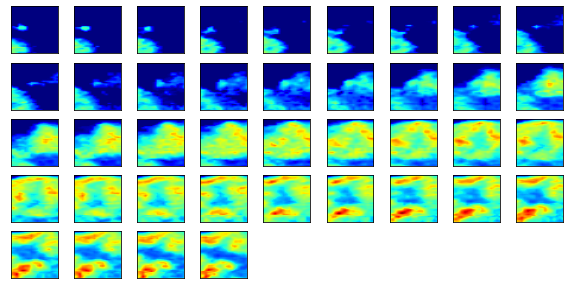

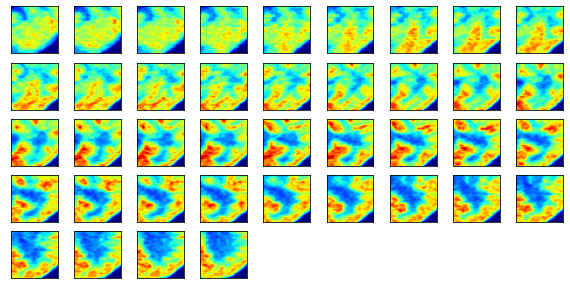

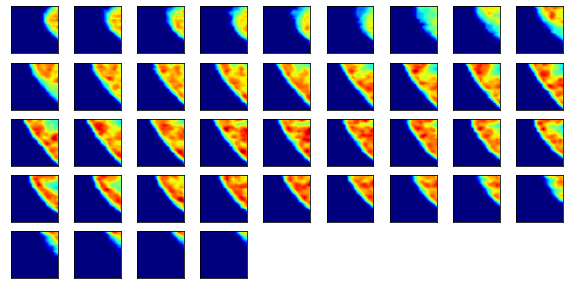

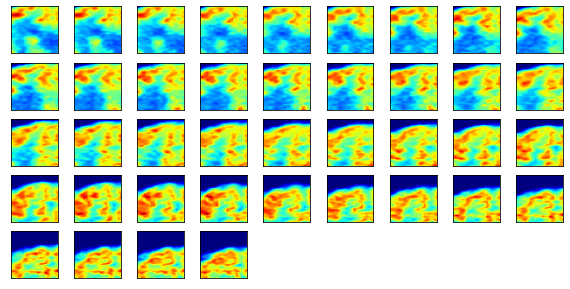

In [47]:
# Roi extraction
segmentation.roi_align(test_image, merge_interesting_boxes, displayed=True);

In [ ]:
""" https://www.analyticsvidsort_index/blog/2020/08/selecting-the-right-bounding-box-using-non-max-suppression-with-implementation/
Step 1: Select the box with highest objectiveness score [Replace with intensity?] - Calculate with nms (package availible in segmentation)
Step 2: Then, compare the overlap (intersection over union) of this box with other boxes 
Step 3: Remove the bounding boxes with overlap (intersection over union) >50%
Step 4: Then, move to the next highest objectiveness score
Step 5: Finally, repeat steps 2-4
"""